In [1]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from dotenv import load_dotenv
sys.path.insert(0, '..')

from core.genetic_algorithm.ga_member import Member
from core.genetic_algorithm.ga_params import GeneticAlgorithmParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances

## Model Parameters

In [2]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt = 0.1, # hours/step
    simulation_hours = 2900 # hours
)

In [3]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [4]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [5]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Input Disturbances

In [6]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../io/inputs/hourly_prcp_rad_temp_iowa.csv',
    header=None,
    names=[
        'Hourly Precipitation (mm)',
        'Hourly Radiation (W/m2)',
        'Temperature (C)'
    ]
)

In [7]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (mm)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Control Inputs

In [8]:
irrigation_frequency = 24 * 7 * 2 # once every X hours
irrigation_amount    = 0.1        # inches per irrigation
fertilizer_frequency = 24 * 30    # once every X hours
fertilizer_amount    = 100        # lbs per fertilization  

In [9]:
# Apply irrigation and fertilizer based on the defined frequency and amount
simulation_hours = len(input_disturbances.precipitation)
hourly_irrigation = np.zeros(simulation_hours)
for t in range(0, simulation_hours, irrigation_frequency):
    hourly_irrigation[t] = irrigation_amount

hourly_fertilizer = np.zeros(simulation_hours)
for t in range(0, simulation_hours, fertilizer_frequency):
    hourly_fertilizer[t] = fertilizer_amount

## Plot inputs and distrubances

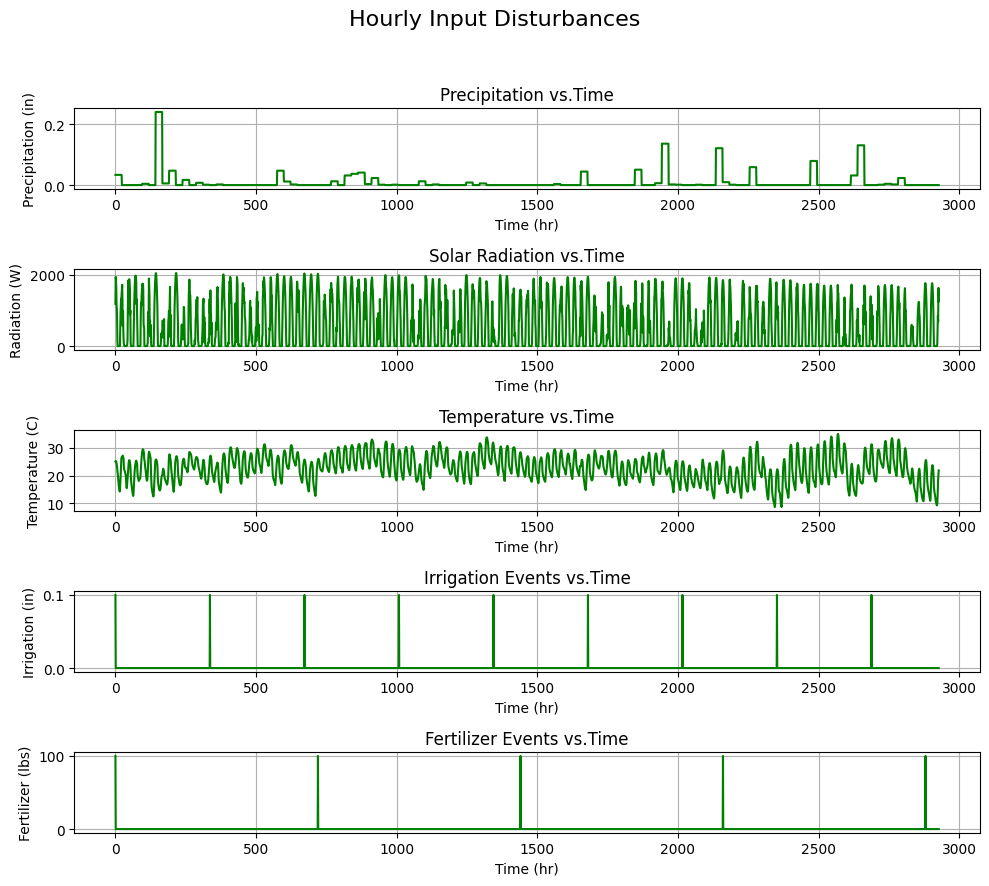

In [10]:
# Plot all of the input disturbances and control inputs
fig, axs = plt.subplots(5, 1, figsize=(10, 9))
time = np.arange(len(input_disturbances.precipitation))

# Precipitation
axs[0].plot(time, input_disturbances.precipitation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Precipitation (in)')
axs[0].set_title(f'Precipitation vs.Time')
axs[0].grid(True)

# Solar Radiation
axs[1].plot(time, input_disturbances.radiation, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Radiation (W)')
axs[1].set_title(f'Solar Radiation vs.Time')
axs[1].grid(True)

# Fruit Biomass
axs[2].plot(time, input_disturbances.temperature, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Temperature (C)')
axs[2].set_title(f'Temperature vs.Time')
axs[2].grid(True)

# Irrigation Events
axs[3].plot(time, hourly_irrigation, color='green')
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Irrigation (in)')
axs[3].set_title(f'Irrigation Events vs.Time')
axs[3].grid(True)

# Fertilizer Events
axs[4].plot(time, hourly_fertilizer, color='green')
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Fertilizer (lbs)')
axs[4].set_title(f'Fertilizer Events vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Input Disturbances', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Optimal/Typical Values

In [11]:
typical_disturbances = ModelTypicalDisturbances(
        #optimal_cumulative_water      = 9e-3,  # inches/acre per hour (28 inches/acre per season)
        #optimal_cumulative_fertilizer = 0.118, # lbs/acre per hour (355 lbs/acre per season)
        optimal_cumulative_water      = 9e-3,
        optimal_cumulative_fertilizer = 0.118,
        #typical_temperature           = np.mean(input_disturbances.temperature),   # typical temperature over the season
        #typical_radiation             = 3/4 * np.max(input_disturbances.radiation) # typical radiation over the season
        typical_temperature=21.8,
        typical_radiation=500
    )

## GA Params (just to use Member class)

In [12]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams(
    num_parents     = 10,  # number of design strings to breed
    num_kids        = 10,  # number of offspring design strings
    num_generations = 200, # number of generations
    num_members     = 100, # number of simulations per generation
    weight_height   = 0.5, # weight for height in cost function
    weight_biomass  = 0.5  # weight for fruit biomass in cost function
)

## Simulation of Plant Growth over Season

In [13]:
# Construct an instance of the Member class and get the cost
member = Member(
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
)
h, A, N, c, P, nuW_values, nuF_values, nuT_values, nuR_values, ah_hat_values, aA_hat_values, aN_hat_values, ac_hat_values, aP_hat_values, kh_hat_values, kA_hat_values, kN_hat_values, kc_hat_values, kP_hat_values = member.get_cost_verbose()

## Plot crop growth results

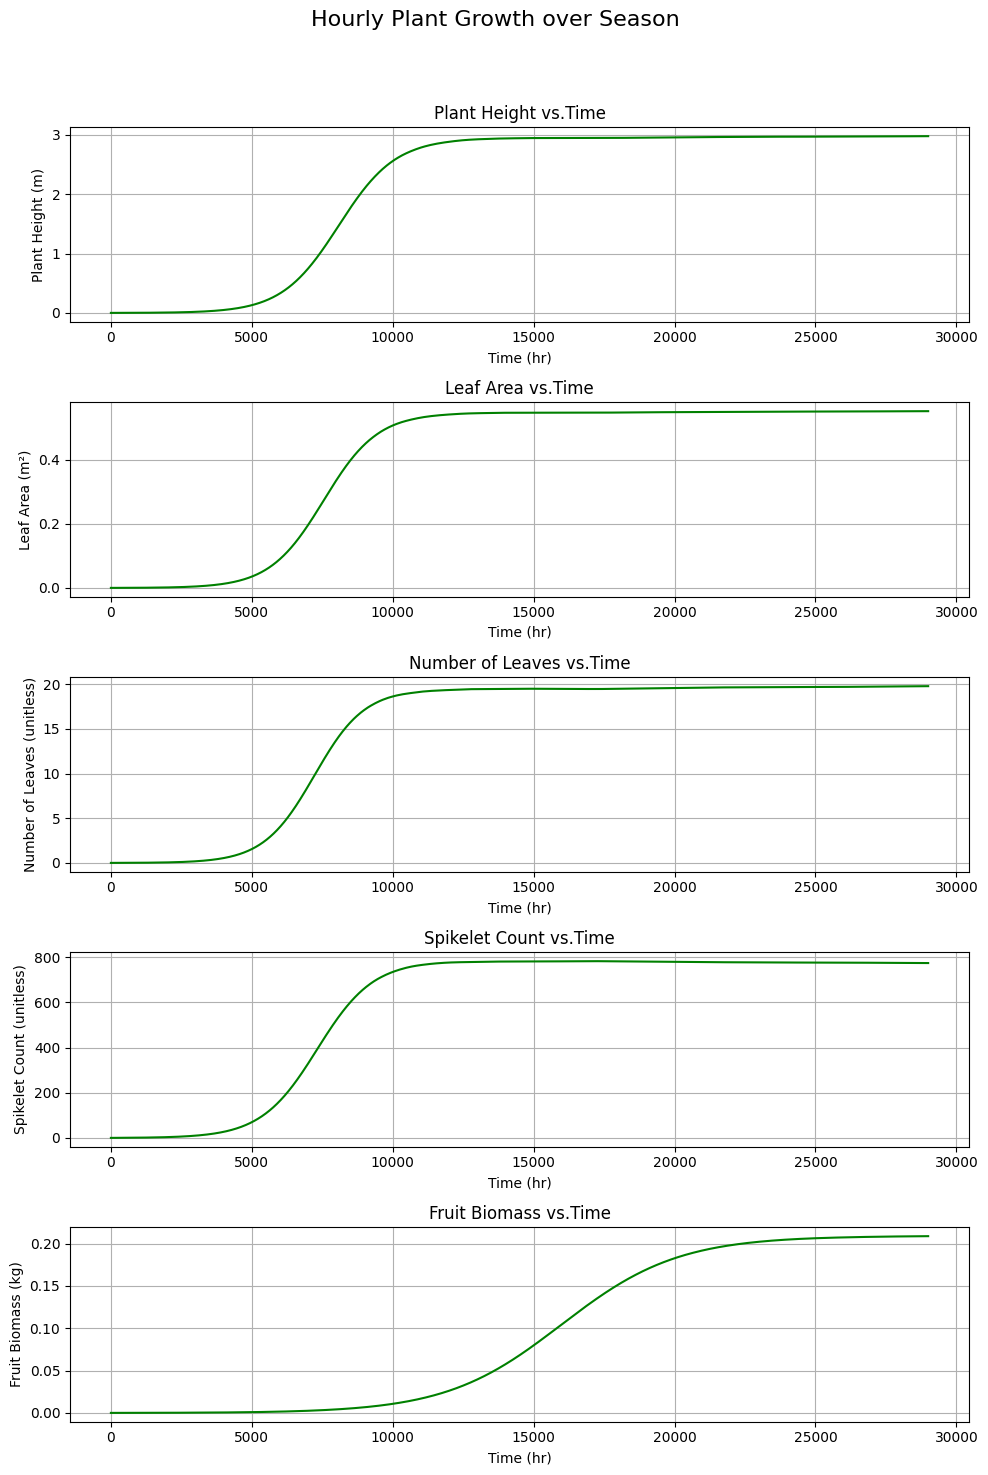

In [14]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time = np.arange(len(h))

# Plant Height
axs[0].plot(time, h, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Plant Height (m)')
axs[0].set_title(f'Plant Height vs.Time')
axs[0].grid(True)

# Leaf Area
axs[1].plot(time, A, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Leaf Area (m²)')
axs[1].set_title(f'Leaf Area vs.Time')
axs[1].grid(True)

# Number of Leaves
axs[2].plot(time, N, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Number of Leaves (unitless)')
axs[2].set_title(f'Number of Leaves vs.Time')
axs[2].grid(True)

# Spikelet Count
axs[3].plot(time, c, color='green')
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Spikelet Count (unitless)')
axs[3].set_title(f'Spikelet Count vs.Time')
axs[3].grid(True)

# Fruit Biomass
axs[4].plot(time, P, color='green')
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Fruit Biomass (kg)')
axs[4].set_title(f'Fruit Biomass vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Plant Growth over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot nutrient factor evolution

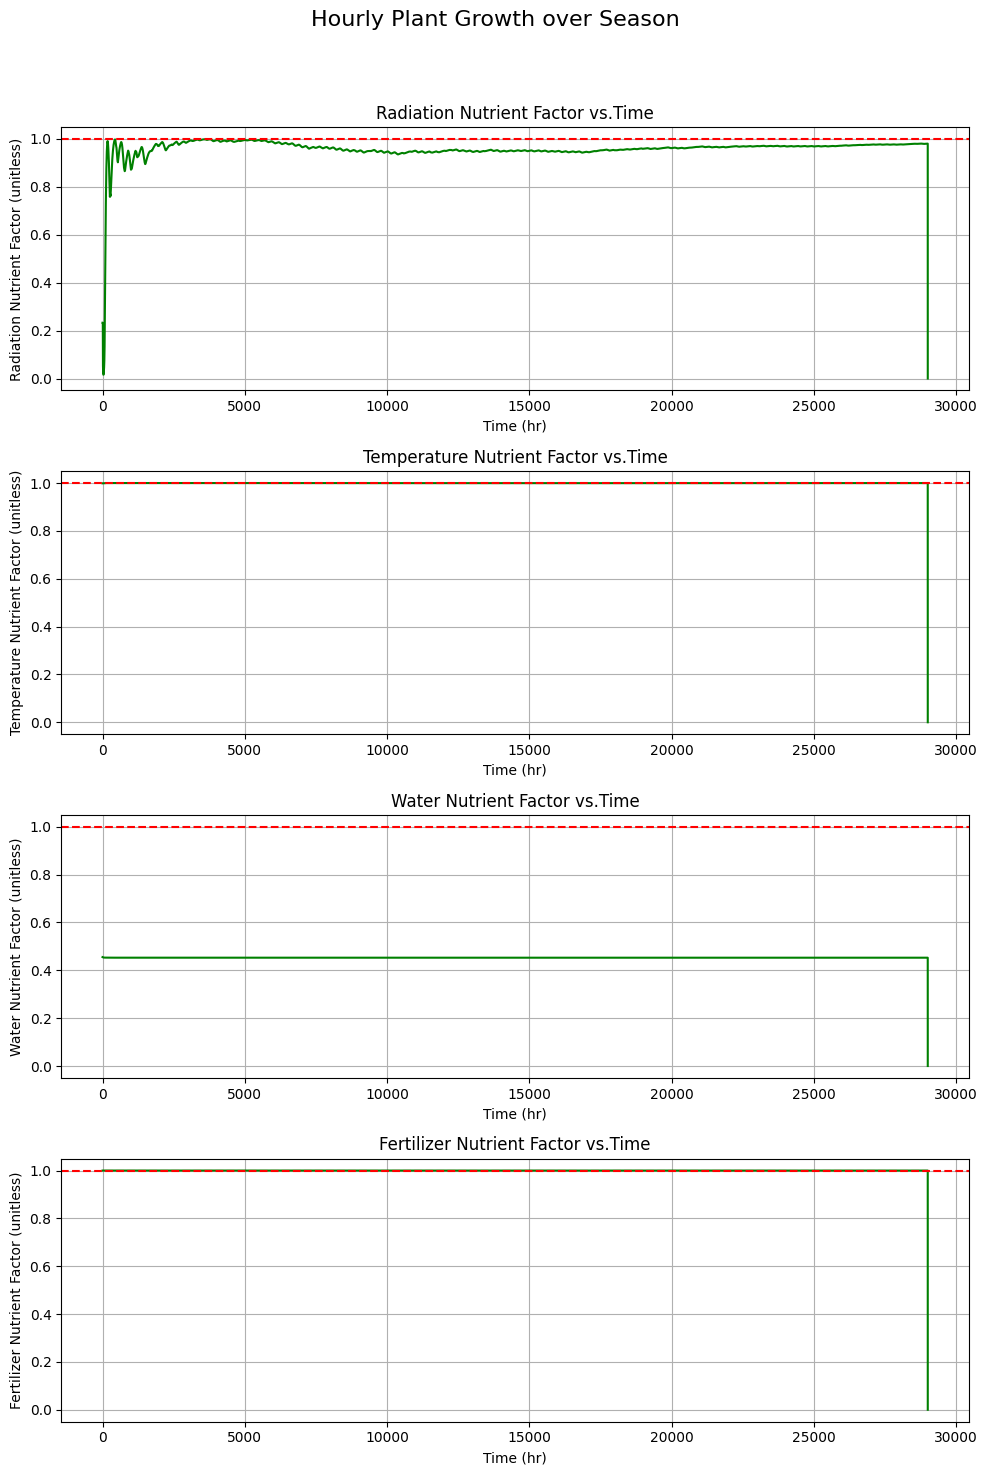

In [15]:
# Plot nuW, nuF, nuT, and nuF over time
fig, axs = plt.subplots(4, 1, figsize=(10, 15))
time = np.arange(len(nuW_values))

# Radiation Nutrient Factor
axs[0].plot(time, nuR_values, color='green')
axs[0].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Radiation Nutrient Factor (unitless)')
axs[0].set_title(f'Radiation Nutrient Factor vs.Time')
axs[0].grid(True)

# Temperature Nutrient Factor
axs[1].plot(time, nuT_values, color='green')
axs[1].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Temperature Nutrient Factor (unitless)')
axs[1].set_title(f'Temperature Nutrient Factor vs.Time')
axs[1].grid(True)

# Water Nutrient Factor
axs[2].plot(time, nuW_values, color='green')
axs[2].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Water Nutrient Factor (unitless)')
axs[2].set_title(f'Water Nutrient Factor vs.Time')
axs[2].grid(True)

# Fertilizer Nutrient Factor
axs[3].plot(time, nuF_values, color='green')
axs[3].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Fertilizer Nutrient Factor (unitless)')
axs[3].set_title(f'Fertilizer Nutrient Factor vs.Time')
axs[3].grid(True)

fig.suptitle(f'Hourly Plant Growth over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot growth rates over time

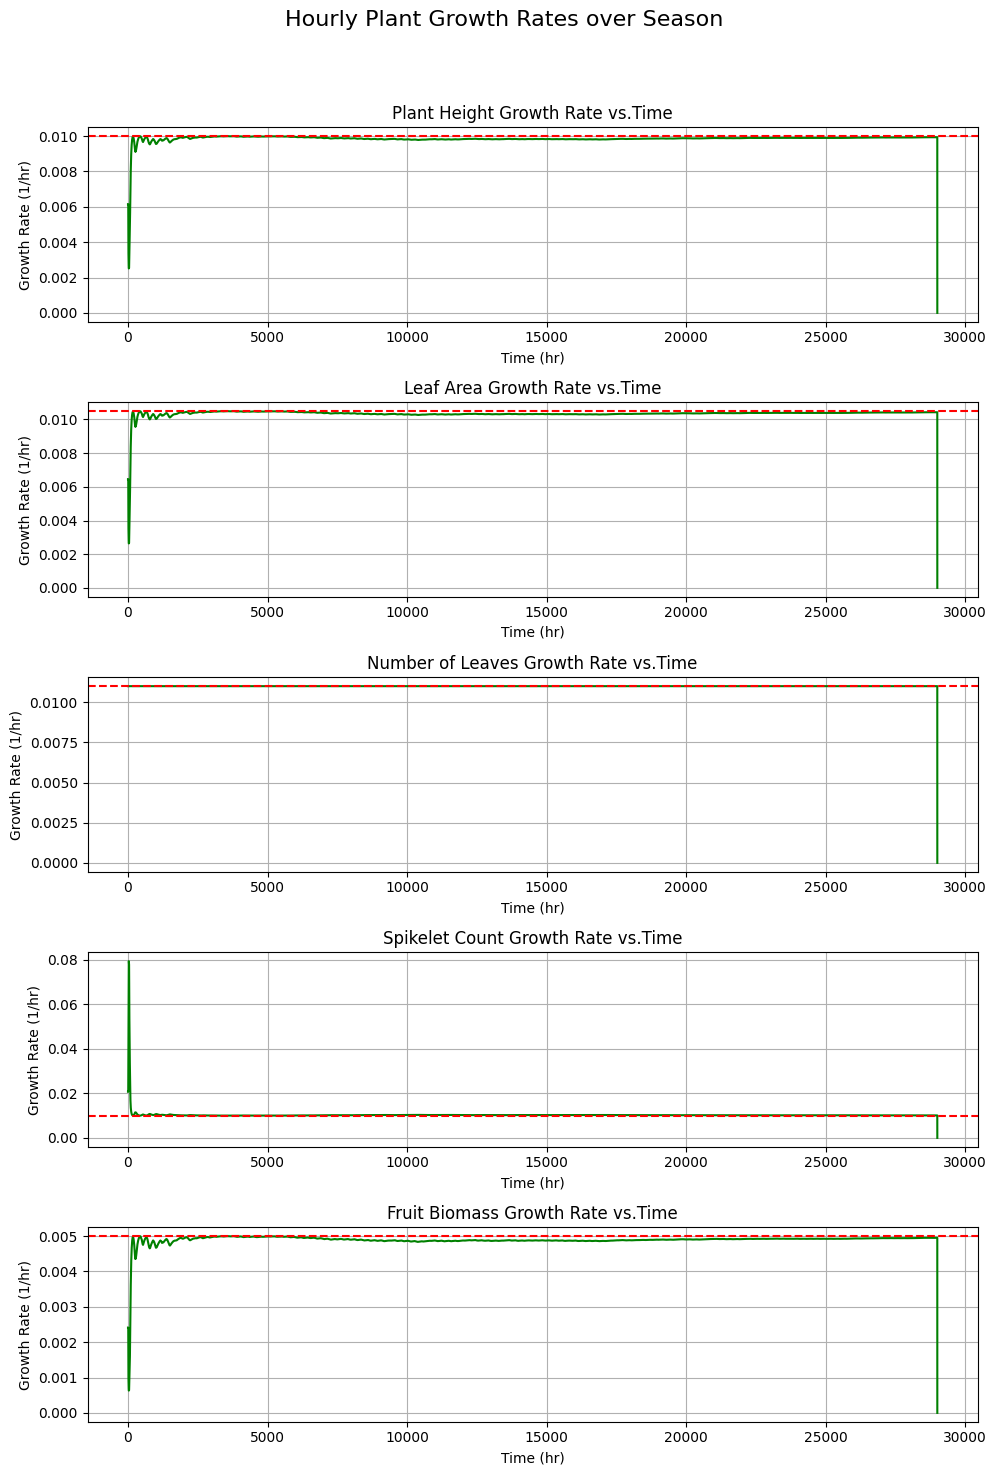

In [16]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time = np.arange(len(ah_hat_values))

# Plant Height Growth Rate
axs[0].plot(time, ah_hat_values, color='green')
axs[0].axhline(y=growth_rates.ah, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Growth Rate (1/hr)')
axs[0].set_title(f'Plant Height Growth Rate vs.Time')
axs[0].grid(True)

# Leaf Area Growth Rate
axs[1].plot(time, aA_hat_values, color='green')
axs[1].axhline(y=growth_rates.aA, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Growth Rate (1/hr)')
axs[1].set_title(f'Leaf Area Growth Rate vs.Time')
axs[1].grid(True)

# Number of Leaves Growth Rate
axs[2].plot(time, aN_hat_values, color='green')
axs[2].axhline(y=growth_rates.aN, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Growth Rate (1/hr)')
axs[2].set_title(f'Number of Leaves Growth Rate vs.Time')
axs[2].grid(True)

# Spikelet Count Growth Rate
axs[3].plot(time, ac_hat_values, color='green')
axs[3].axhline(y=growth_rates.ac, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Growth Rate (1/hr)')
axs[3].set_title(f'Spikelet Count Growth Rate vs.Time')
axs[3].grid(True)

# Fruit Biomass Growth Rate
axs[4].plot(time, aP_hat_values, color='green')
axs[4].axhline(y=growth_rates.aP, color='red', linestyle='--', linewidth=1.5)
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Growth Rate (1/hr)')
axs[4].set_title(f'Fruit Biomass Growth Rate vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Plant Growth Rates over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot carrying capacities over time

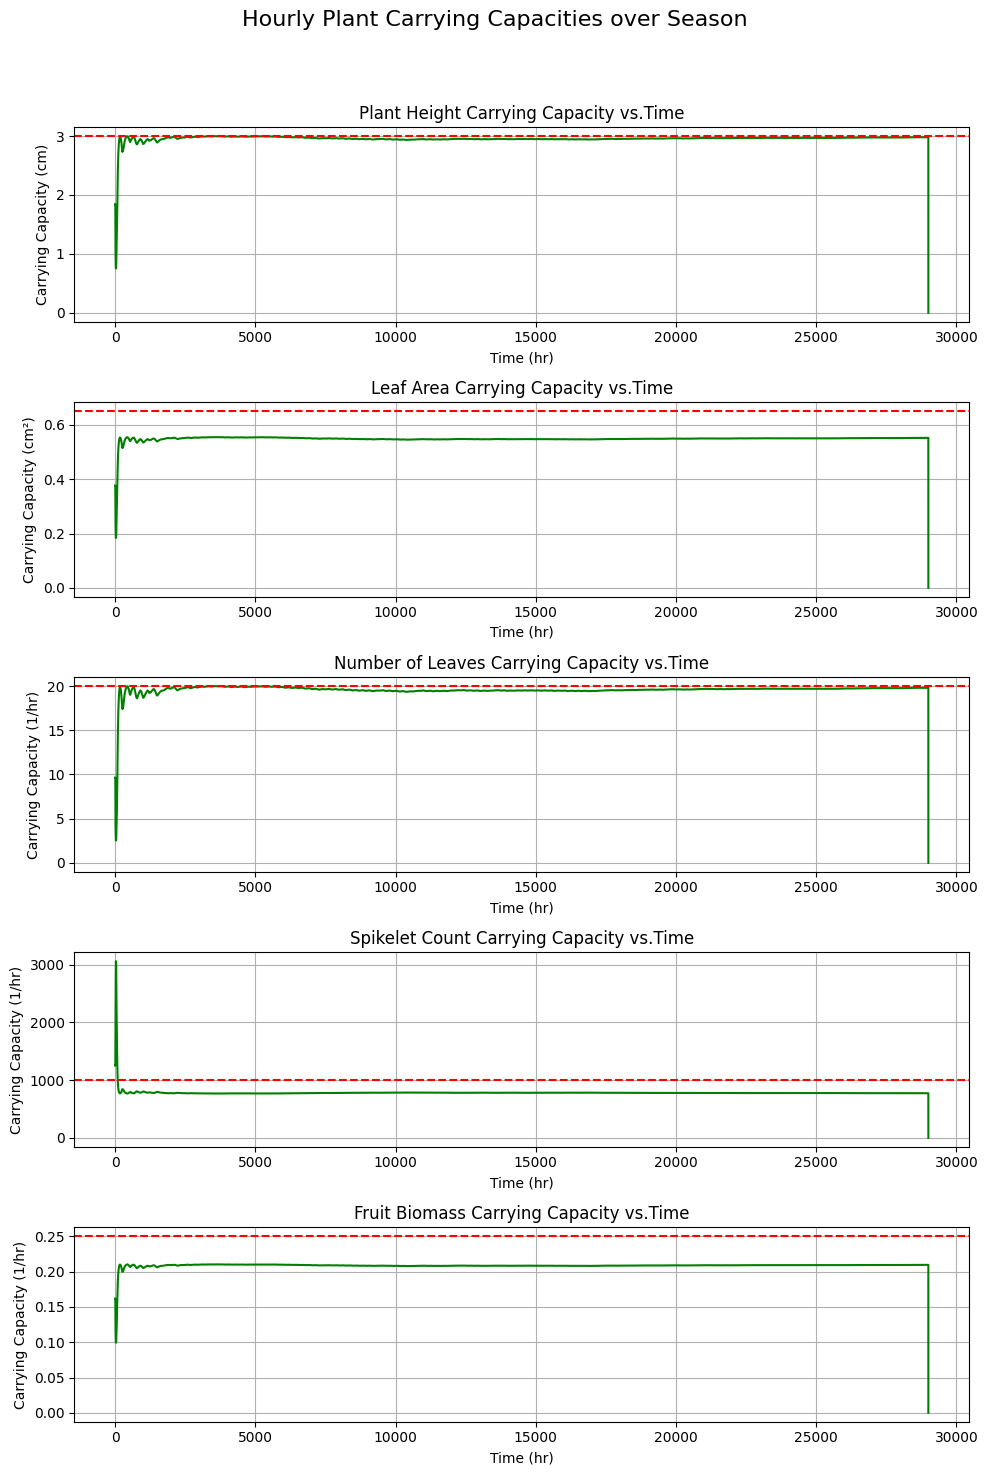

In [17]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time = np.arange(len(kh_hat_values))

# Plant Height Carrying Capacity
axs[0].plot(time, kh_hat_values, color='green')
axs[0].axhline(y=carrying_capacities.kh, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Carrying Capacity (cm)')
axs[0].set_title(f'Plant Height Carrying Capacity vs.Time')
axs[0].grid(True)

# Leaf Area Carrying Capacity
axs[1].plot(time, kA_hat_values, color='green')
axs[1].axhline(y=carrying_capacities.kA, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Carrying Capacity (cm²)')
axs[1].set_title(f'Leaf Area Carrying Capacity vs.Time')
axs[1].grid(True)

# Number of Leaves Carrying Capacity
axs[2].plot(time, kN_hat_values, color='green')
axs[2].axhline(y=carrying_capacities.kN, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Carrying Capacity (1/hr)')
axs[2].set_title(f'Number of Leaves Carrying Capacity vs.Time')
axs[2].grid(True)

# Spikelet Count Carrying Capacity
axs[3].plot(time, kc_hat_values, color='green')
axs[3].axhline(y=carrying_capacities.kc, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Carrying Capacity (1/hr)')
axs[3].set_title(f'Spikelet Count Carrying Capacity vs.Time')
axs[3].grid(True)

# Fruit Biomass Carrying Capacity
axs[4].plot(time, kP_hat_values, color='green')
axs[4].axhline(y=carrying_capacities.kP, color='red', linestyle='--', linewidth=1.5)
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Carrying Capacity (1/hr)')
axs[4].set_title(f'Fruit Biomass Carrying Capacity vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Plant Carrying Capacities over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()